In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -qr yolov5/requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 13003, done.
remote: Total 13003 (delta 0), reused 0 (delta 0), pack-reused 13003
Receiving objects: 100% (13003/13003), 11.91 MiB | 31.18 MiB/s, done.
Resolving deltas: 100% (9031/9031), done.
     |████████████████████████████████| 596 kB 37.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path_an = "/content/drive/MyDrive/mask detection project/input/annotations"

In [ ]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

In [ ]:
for anno in glob.glob(path_an+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [ ]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss109,with_mask,400,400,216,92,372,251
1,maksssksksss106,with_mask,600,399,154,51,423,391
2,maksssksksss101,with_mask,301,400,48,294,164,400
3,maksssksksss110,without_mask,400,267,6,111,43,148
4,maksssksksss110,without_mask,400,267,22,20,49,46


In [ ]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

In [ ]:
df['class'] = df['name'].map(name_dict)

In [ ]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [ ]:
fileNames = [*os.listdir("/content/drive/MyDrive/mask detection project/input/images")]
len(fileNames)

853

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [ ]:
os.mkdir('/content/yolov5/data/train')
os.mkdir('/content/yolov5/data/val')
os.mkdir('/content/yolov5/data/test')
os.mkdir('/content/yolov5/data/train/images')
os.mkdir('/content/yolov5/data/train/labels')
os.mkdir('/content/yolov5/data/test/images')
os.mkdir('/content/yolov5/data/test/labels')
os.mkdir('/content/yolov5/data/val/images')
os.mkdir('/content/yolov5/data/val/labels')

In [ ]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open("/content/drive/MyDrive/mask detection project/input/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save("/content/yolov5/data/"+folder_Name+"/images/"+image)
        

In [ ]:
copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [ ]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss109,with_mask,400,400,216,92,372,251,0
1,maksssksksss106,with_mask,600,399,154,51,423,391,0
2,maksssksksss101,with_mask,301,400,48,294,164,400,0
3,maksssksksss110,without_mask,400,267,6,111,43,148,2
4,maksssksksss110,without_mask,400,267,22,20,49,46,2


In [ ]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [ ]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [ ]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [ ]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss109,with_mask,400,400,345,110,595,301,0,0.734375,0.428125,0.390625,0.397917
1,maksssksksss106,with_mask,600,399,164,61,451,470,0,0.480469,0.553125,0.448437,0.852083
2,maksssksksss101,with_mask,301,400,102,352,348,480,0,0.351562,0.866667,0.384375,0.266667
3,maksssksksss110,without_mask,400,267,9,199,68,266,2,0.060156,0.484375,0.092188,0.139583
4,maksssksksss110,without_mask,400,267,35,35,78,82,2,0.088281,0.121875,0.067187,0.097917


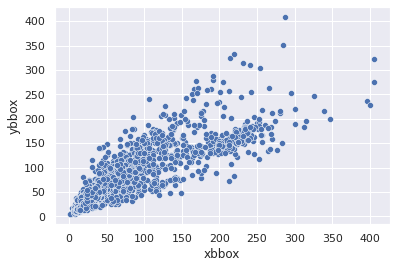

In [ ]:
df['xbbox'] = df['xmax']-df['xmin']
df['ybbox'] = df['ymax']-df['ymin']

sns.set()
sns.scatterplot(x='xbbox',  y='ybbox', data=df)
plt.show()

In [ ]:
df = df.astype('string')

In [ ]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open("./yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)      

In [ ]:
create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
!pip install IPython
from IPython.core.display import Video
from IPython.display import Image, clear_output  # to display images
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.7/78.2 GB disk)


In [ ]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [ ]:
with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [ ]:
%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hs

In [ ]:
print("Runtime =",end-start)

Runtime = 0:30:10.266690


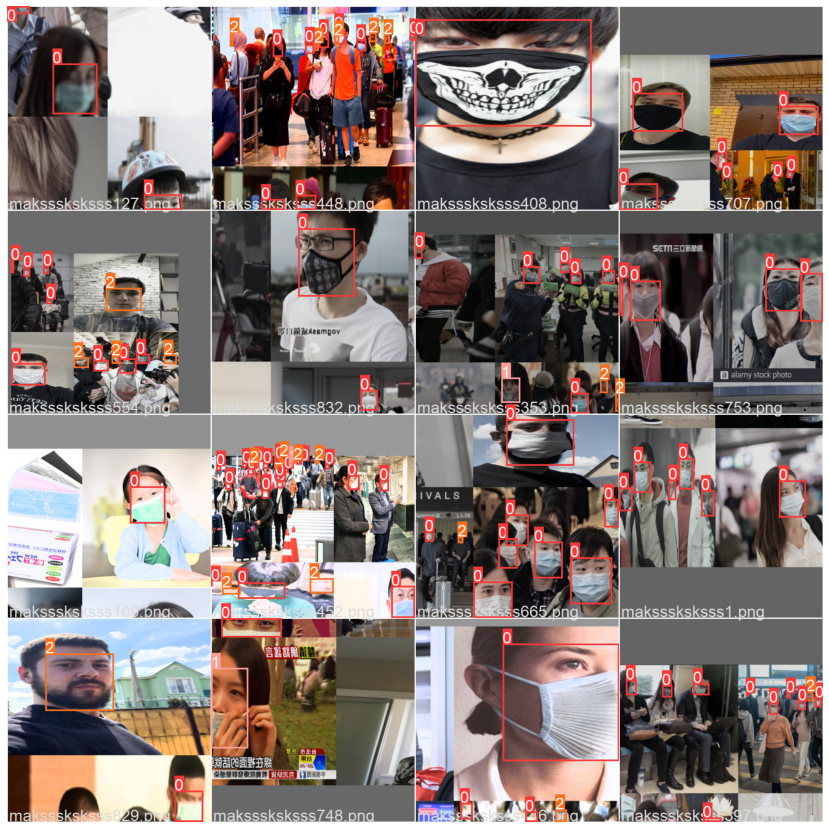

In [ ]:
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

## evolution

In [ ]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
image 1/25 /content/yolov5/data/test/images/maksssksksss0.png: 480x640 1 with_mask, 2 without_masks, Done. (0.025s)
image 2/25 /content/yolov5/data/test/images/maksssksksss126.png: 480x640 2 with_masks, Done. (0.018s)
image 3/25 /content/yolov5/data/test/images/maksssksksss131.png: 480x640 4 with_masks, 2 without_masks, Done. (0.018s)
image 4/25

In [ ]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [ ]:
def show_image(img_id,out=False):
    df_image = df[df.file==img_id]

    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    if len(df_image)>0:
      path = 'data/test/images/'+img_id+'.png'
    else:
      path = img_id
      
    img = plt.imread(path)
    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)
    if out:
      print(img_id)
      img_pred = plt.imread(img_id)
    else:
      img_pred = plt.imread('runs/detect/expTestImage/'+img_id+".png")
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/content/test3.jpeg


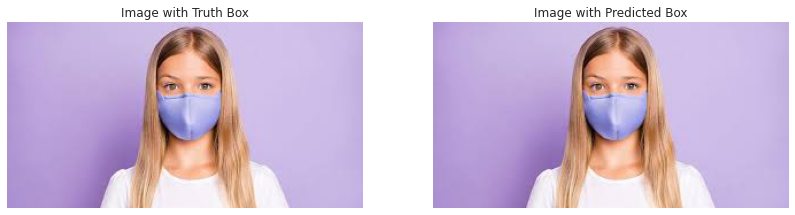

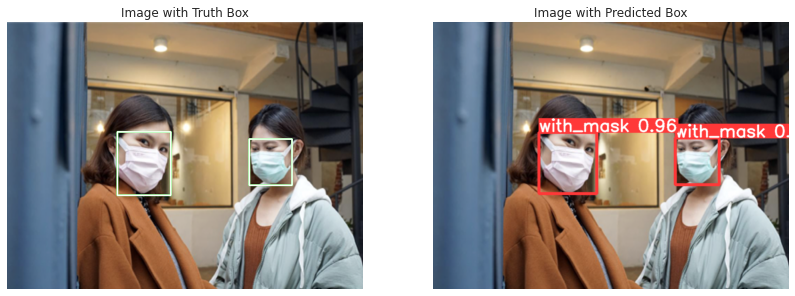

In [ ]:
show_image("/content/test3.jpeg",True) 
show_image("maksssksksss315") 
plt.show()

In [81]:
# zip the whole folder, for downloading 

!zip -r /content/yolov5.zip /content/yolov5

  adding: content/yolov5/ (stored 0%)
  adding: content/yolov5/.git/ (stored 0%)
  adding: content/yolov5/.git/index (deflated 53%)
  adding: content/yolov5/.git/FETCH_HEAD (deflated 70%)
  adding: content/yolov5/.git/info/ (stored 0%)
  adding: content/yolov5/.git/info/exclude (deflated 28%)
  adding: content/yolov5/.git/description (deflated 14%)
  adding: content/yolov5/.git/packed-refs (deflated 54%)
  adding: content/yolov5/.git/HEAD (stored 0%)
  adding: content/yolov5/.git/hooks/ (stored 0%)
  adding: content/yolov5/.git/hooks/fsmonitor-watchman.sample (deflated 53%)
  adding: content/yolov5/.git/hooks/commit-msg.sample (deflated 44%)
  adding: content/yolov5/.git/hooks/pre-applypatch.sample (deflated 38%)
  adding: content/yolov5/.git/hooks/applypatch-msg.sample (deflated 42%)
  adding: content/yolov5/.git/hooks/update.sample (deflated 68%)
  adding: content/yolov5/.git/hooks/pre-push.sample (deflated 50%)
  adding: content/yolov5/.git/hooks/post-update.sample (deflated 27%)
  

In [ ]:
df

,file,name,width,height,xmin,...,y_center,box_height,box_width,xbbox,ybbox
0,maksssksksss109,with_mask,400,400,345,...,0.428125,0.390625,0.39791666666666664,250,191
1,maksssksksss106,with_mask,600,399,164,...,0.553125,0.4484375,0.8520833333333333,287,409
2,maksssksksss101,with_mask,301,400,102,...,0.8666666666666667,0.384375,0.26666666666666666,246,128
3,maksssksksss110,without_mask,400,267,9,...,0.484375,0.0921875,0.13958333333333334,59,67
4,maksssksksss110,without_mask,400,267,35,...,0.121875,0.0671875,0.09791666666666667,43,47
...,...,...,...,...,...,...,...,...,...,...,...
4067,maksssksksss176,mask_weared_incorrect,400,225,379,...,0.490625,0.1,0.21875,64,105
4068,maksssksksss176,without_mask,400,225,465,...,0.43020833333333336,0.0703125,0.16041666666666668,45,77
4069,maksssksksss176,without_mask,400,225,593,...,0.33958333333333335,0.053125,0.12083333333333333,34,58
4070,maksssksksss176,without_mask,400,225,619,...,0.334375,0.0328125,0.14791666666666667,21,71


Detect video

In [ ]:
%cd ../

/content


In [80]:
!python yolov5/detect.py --source /content/medical.mp4 --weight yolov5/runs/train/yolov5s_results/weights/best.pt --name video --conf 0.4

detect: weights=['yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/medical.mp4, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=video, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
video 1/1 (1/310) /content/medical.mp4: 384x640 1 without_mask, Done. (0.019s)
video 1/1 (2/310) /content/medical.mp4: 384x640 1 without_mask, Done. (0.018s)
video 1/1 (3/310) /content/medical.mp4: 384x640 1 without_mask, Done. (0.018s)
video 1/1 (4/310) /content/medical.mp4: 384x640 1 without_mask, Done. (0.019s)
video 1/1 (5/3